# Compare Speaker Diarization Pipelines

In this notebook, differen speaker diarization pipelines will be compared in terms of performance. The following pipelines for speaker representation will be compared:

- Speechbrains [pretrained ECAPA-TDNN](https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb) model with default settings as in `model.encode_batch()`
- The pretrained [UniSpeech-SAT](https://huggingface.co/docs/transformers/model_doc/unispeech-sat) model in the `transformers` package with default settings
- The pretrained [WavLM](https://huggingface.co/docs/transformers/model_doc/wavlm) model in the `transformers` package with default settings

All models receive preprocessed audio signals from the `transformers` [Wav2Vec2FeatureExtractor](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2FeatureExtractor) with padding and normalization enabled. Audio segments that are longer than 20s are split into equal sized subsegments and encoded separately. Afterwards, the encodings are averaged over the subsegments (thus, there is one embedding vector for each segment in the end). The embeddings are normalized.

For speaker representation clustering, three methods will be compared:
- Spectral clustering
- Agglomerative clustering
- K-means

all from the `sklearn.cluster` package with default settings and four clusters (equal to the amount of speakers).

The pipelines will be compared using four metrics (diarization error rate, jaccard error rate, coverage, and purity) as described [here](https://pyannote.github.io/pyannote-metrics/reference.html#diarization).

In [1]:
from rttm import read_rttm
from pyannote.core import Annotation, Timeline, Segment
from pyannote.metrics.diarization import DiarizationErrorRate, JaccardErrorRate, DiarizationCoverage, DiarizationPurity
from scipy.stats import beta
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
RESULTS = ["speechbrain-ecapa-tdnn",
           "transformers-unisat", "transformers-wavlm"]


In [3]:
CLUSTER_METHODS = ["sc", "ac", "km"]

In [4]:
FILE_INDICES = list(range(16))

In [5]:
diarization_der = DiarizationErrorRate(collar=0.25)
diarization_jer = JaccardErrorRate(collar=0.25)
diarization_coverage = DiarizationCoverage(collar=0.25)
diarization_purity = DiarizationPurity(collar=0.25)


In [6]:
def convert_rttm_annotation(rttm_seq):
    annotation = Annotation()
    for seg in rttm_seq.sequence:
        annotation[Segment(seg.tbeg, seg.tbeg+seg.tdur)] = seg.name

    return annotation


In [7]:
results_df = {"metric": [], "method": [], "cluster": [], "value": []}

method_labels = {
    "speechbrain-ecapa-tdnn": "sb_ecapa_tdnn",
    "transformers-unisat": "tr_unisat",
    "transformers-wavlm": "tr_wavlm"
}

for res_dir in RESULTS:
    for cm in CLUSTER_METHODS:
        for i in FILE_INDICES:
            with os.scandir(os.path.join("results", res_dir)) as filenames:
                for filename in filenames:
                    cluster_method = filename.name.split("_")[0]
                    index = int(filename.name.split("_")[-1].split(".")[0])
                    if cluster_method == cm and index == i:
                        res_rttm_seq = read_rttm(filename.path)
                        ref_rttm_seq = read_rttm(os.path.join("results", "reference", f"ref_ami_micro_test_sample_{i}.rttm"))
                        assert os.path.split(os.path.normpath(ref_rttm_seq.sequence[0].file))[-1] == os.path.split(os.path.normpath(res_rttm_seq.sequence[0].file))[-1]
                        res_annotation = convert_rttm_annotation(res_rttm_seq)
                        ref_annotation = convert_rttm_annotation(ref_rttm_seq)
                        der = diarization_der(ref_annotation, res_annotation)
                        jer = diarization_jer(ref_annotation, res_annotation)
                        coverage = diarization_coverage(ref_annotation, res_annotation)
                        purity = diarization_purity(ref_annotation, res_annotation)
                        results_df["metric"] = results_df["metric"] + ["der", "jer", "coverage", "purity"]
                        results_df["method"] = results_df["method"] + [method_labels[res_dir]] * 4
                        results_df["cluster"] = results_df["cluster"] + [cm] * 4
                        results_df["value"] = results_df["value"] + [der, jer, coverage, purity]
                        
results_df = pd.DataFrame(results_df)

c:\Users\MalteLuken\Repositories\mexca-sd-experiment\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [8]:
def select_min_max(group):
    if pd.DataFrame(group).reset_index()["metric"].apply(lambda x: x in ["der", "jer"]).all():
        return np.min(group)
    else:
        return np.max(group)


In [9]:
mean_results_df = results_df.groupby(["metric", "method", "cluster"]).aggregate(np.mean)

mean_best_results_dict = mean_results_df.groupby(
    ["cluster", "metric"]).aggregate(select_min_max).to_dict()["value"]


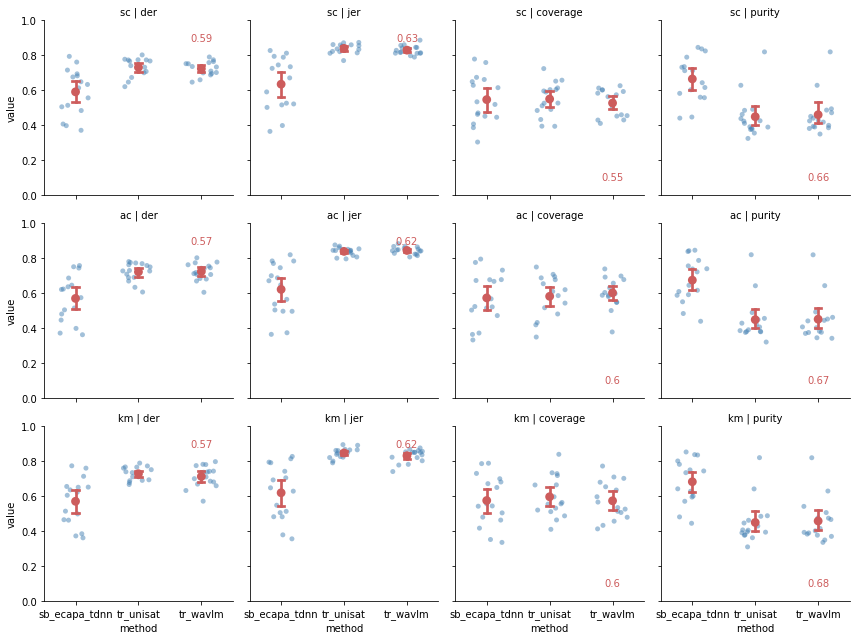

In [10]:
grid = sns.FacetGrid(data=results_df, col="metric", row="cluster")

grid.map(sns.stripplot, "method", "value", color="steelblue",
         order=method_labels.values(), alpha=0.5, jitter=0.25, zorder=1)
grid.map(sns.pointplot, "method", "value", color="indianred", join=False,
         order=method_labels.values(), estimator=np.mean, capsize=0.1, zorder=2)

grid.set_titles(col_template="{col_name}", row_template="{row_name}")
grid.set(ylim=(0.0, 1.0), yticks=np.linspace(0.0, 1.0, 6))

best_pos = {"der": (2, 0.9), "jer": (2, 0.9), "coverage": (2, 0.1), "purity": (2, 0.1)}

for col in grid.axes:
    for row in col:
        metric = tuple(row.title.get_text().split(" | "))
        best = round(mean_best_results_dict[metric], 2)
        row.annotate(text=best, xy=best_pos[metric[1]],
                    ha='center', va='center', color="indianred")

grid.savefig("sd_results.pdf")
grid.savefig("sd_results.png")


The comparison shows that all three speaker representation pipelines and clustering methods perform similarly in terms of DER and JER. Absolutely, all approaches perform badly as the error rate is very high. However, both UniSpeech-SAT and WavLM show high coverage and low purity which is an indication of [undersegmentation](https://pyannote.github.io/pyannote-metrics/reference.html#purity-and-coverage). Thus, the high DER and JER values could be due to the fact that the speech segments from the VAD step are too coarse to allow accurate speaker assignment.

In [13]:
overlap_df = {"file_id": [], "identification_ratio": [], "duration": [], "is_overlap": []}

for i in FILE_INDICES:
    ref_rttm_seq = read_rttm(os.path.join("results", "reference", f"ref_ami_micro_test_sample_{i}.rttm"))
    ref_annotation = convert_rttm_annotation(ref_rttm_seq)
    res_rttm_seq = read_rttm(os.path.join("results", "speechbrain-ecapa-tdnn", f"km_sb_ecapa_tdnn_ami_sample_{i}.rttm"))
    res_annotation = convert_rttm_annotation(res_rttm_seq)

    mapping = diarization_der.optimal_mapping(ref_annotation, res_annotation)

    ref_overlap_timeline = ref_annotation.get_timeline().get_overlap()

    for segment, track, label in ref_annotation.itertracks(yield_label=True):
        mapped_spk = [key for key, val in mapping.items() if val == label][0]
        spk_timeline = res_annotation.subset(mapped_spk).get_timeline()
        identification_dur = 0.0
        for co_seg in spk_timeline.co_iter(Timeline([segment])):
            identification_seg_pair = co_seg[0] & co_seg[1]
            identification_dur += identification_seg_pair.duration

        overlaps = list(ref_overlap_timeline.co_iter(Timeline([segment])))
        
        overlap_df["file_id"].append(i)
        overlap_df["identification_ratio"].append(identification_dur/segment.duration)
        overlap_df["duration"].append(segment.duration)
        overlap_df["is_overlap"].append(any(overlaps))

overlap_df = pd.DataFrame(overlap_df)

In [15]:
total_overlap_df = overlap_df.groupby(["file_id"]).identification_ratio.aggregate([lambda x: np.mean(x > 0.99), lambda x: np.mean(x < 0.01)]).reset_index()

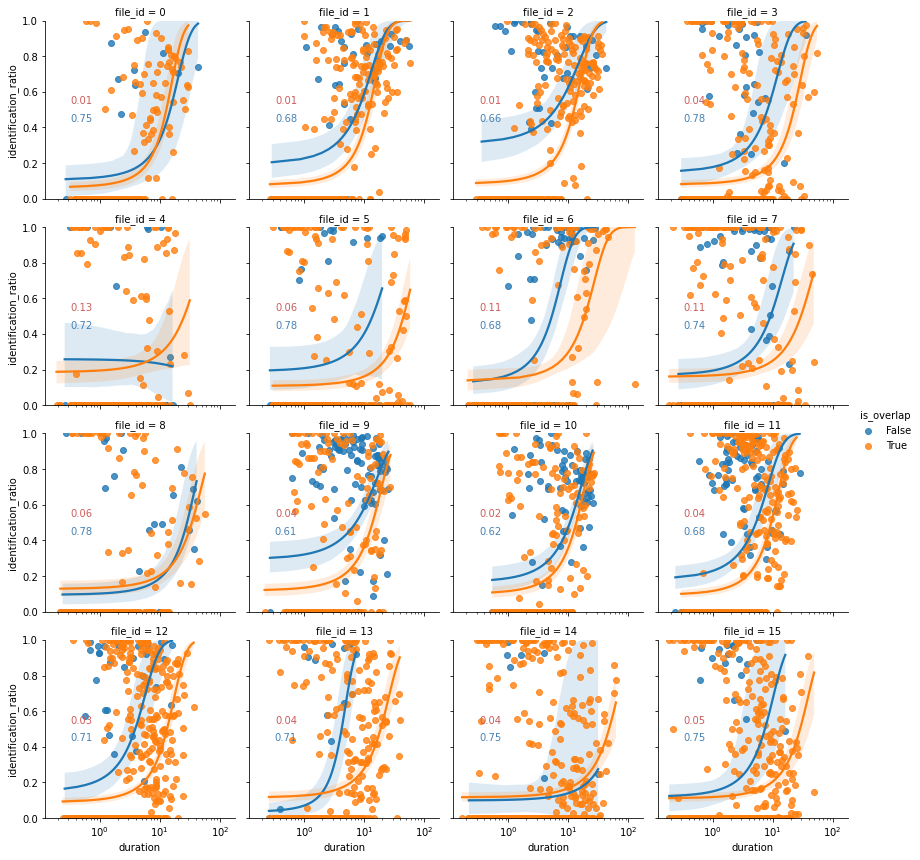

In [16]:
grid = sns.FacetGrid(data=overlap_df, col="file_id", hue="is_overlap", col_wrap=4)

grid.map(sns.regplot, "duration", "identification_ratio", logistic=True)

grid.set(ylim=(0.0, 1.0), xscale="log")

for i, col in enumerate(grid.axes):
    col.annotate(text=round(total_overlap_df.iloc[:,1][i], 2), xy=(0.5, 0.55), ha='center', va='center', color="indianred")
    col.annotate(text=round(total_overlap_df.iloc[:,2][i], 2), xy=(0.5, 0.45), ha='center', va='center', color="steelblue")

grid.add_legend()

grid.savefig("sd_segment_identification.pdf")
grid.savefig("sd_segment_identification.png")

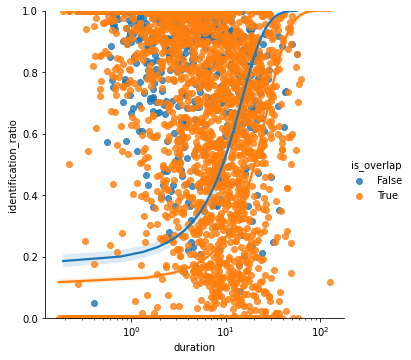

In [17]:
plt = sns.lmplot(x="duration", y="identification_ratio", hue="is_overlap", data=overlap_df, logistic=True)
plt.set(ylim=(0.0, 1.0), xscale="log")